In [90]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

from statsmodels.formula.api import ols



from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings 

warnings.filterwarnings("ignore")

%matplotlib inline

## Goal of this Notebook

I want to start testing which features need to be included or excluded from the analysis.

Things I did: 
- dropped ID
- converted to date to dt
- dropped rennovation column. conducted a ttest between the houses with recent rennovations and without and found there was not significant evidence to reject the null hyptothesis.
- Basement size is important but so is whether or no there is one. I converted it to a dummy column and added it to the model.

In [47]:
df = pd.read_csv('../raw/kc_house_data_train.csv', index_col=0)

In [48]:
# Create new datasets for ease of future use
X = df.drop(columns="price")
X.to_csv("../raw/X.csv", index=False)

y = df['price']
y.to_csv("../raw/y.csv", index=False)

In [5]:
# List of columns to drop, iteratively add to this as I continue
to_drop = [
    'id',
    'yr_renovated'

]
X_train.drop(columns=to_drop, inplace=True)

NameError: name 'X_train' is not defined

In [49]:
# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

In [50]:
X_train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2498,1776460190,20140626T000000,3,2.50,2370,5353,2.0,0,0,3,8,2370,0,2009,0,98019,47.7333,-121.975,2130,6850
10932,2144800215,20140519T000000,4,1.75,2080,13629,1.0,0,0,4,7,1040,1040,1955,0,98178,47.4866,-122.232,1780,14659
15638,7891600165,20140627T000000,1,1.00,700,2500,1.0,0,0,4,7,700,0,1907,0,98106,47.5662,-122.364,1340,5000
15099,8732190200,20150115T000000,4,2.25,2490,7233,1.0,0,0,3,8,1460,1030,1978,0,98023,47.3115,-122.396,2000,8000
15560,9122001230,20141205T000000,3,3.50,1970,5079,2.0,0,0,3,8,1680,290,2007,0,98144,47.5816,-122.296,1940,6000


In [51]:
# List of columns to drop, iteratively add to this as I continue
to_drop = [
    'id',

]
X_train.drop(columns=to_drop, inplace=True)

In [52]:
X_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2498,20140626T000000,3,2.50,2370,5353,2.0,0,0,3,8,2370,0,2009,0,98019,47.7333,-121.975,2130,6850
10932,20140519T000000,4,1.75,2080,13629,1.0,0,0,4,7,1040,1040,1955,0,98178,47.4866,-122.232,1780,14659
15638,20140627T000000,1,1.00,700,2500,1.0,0,0,4,7,700,0,1907,0,98106,47.5662,-122.364,1340,5000
15099,20150115T000000,4,2.25,2490,7233,1.0,0,0,3,8,1460,1030,1978,0,98023,47.3115,-122.396,2000,8000
15560,20141205T000000,3,3.50,1970,5079,2.0,0,0,3,8,1680,290,2007,0,98144,47.5816,-122.296,1940,6000


In [53]:
# Let's handle the date column first by converting it into date time
X_train.date = pd.to_datetime(X_train.date)

In [54]:
# look at the year renovated 
print(len(X_train.yr_renovated.value_counts()))
# 67 unique years. Let's rename the column to year since last renovation 

def years_passed(x, year=2014):
    return year-x

X_train['recent_reno'] = X_train.yr_renovated.apply(lambda x: years_passed(x)).value_counts()
# Given that the majority of houses have not been renovated, we should instead make 3 cats
# 

67


### Hypothesis Alert!!! 
- renovations in the past 10 years will have effect on the price of the house
- alternative, there will be a signeficant effect

In [55]:
def recent_rennovation (n):
    if n <= 10:
        return 1
    else:
        return 0

X_train.recent_reno = X_train.recent_reno.apply(recent_rennovation)

In [56]:
# perform a two way ttest
test = pd.concat([X_train, y_train], axis=1)
x = test[test.recent_reno == 1]
y = test[test.recent_reno == 0]
stats.ttest_ind(x.price, y.price, equal_var=False)

Ttest_indResult(statistic=0.6136789990311201, pvalue=0.5440271138210075)

### Conclusion Alert!!
- I have concluded tentatively that there is no effect of renovation on the outcome of the price.
- A caveat is that the data sets are so vastly different that it is hard to draw a conclusion. 

In [57]:
# Let's have a look at the year built and its effect on our model

# let's perform a simple linear regression 
formula = 'price~yr_built'
model = ols(formula=formula, data = pd.concat([X_train, y_train], axis=1)).fit()

In [58]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     43.12
Date:                Sun, 18 Oct 2020   Prob (F-statistic):           5.33e-11
Time:                        10:00:26   Log-Likelihood:            -1.9715e+05
No. Observations:               13832   AIC:                         3.943e+05
Df Residuals:                   13830   BIC:                         3.943e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -8.613e+05   2.14e+05     -4.028      0.000   -1.28e+06   -4.42e+05
yr_built     712.3704    108.484      6.567      0.000     499.727     925.014
==============================================================================
Omnibus:                    13073.950   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1014162.003
Skew:                           4.379   Prob(JB):                         0.00
Kurtosis:                      44.024   Cond. No.                     1.32e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
# That wasn't significant, but what if we do some feature normalization and modify the column
house_age = X_train.yr_built.apply(years_passed)
X_train['age'] = house_age
scalar = StandardScaler()
# norm_age = scalar.fit_transform(house_age)
# X_train['norm_age'] = norm_age


In [60]:
X_train['norm_age]

2498       5
10932     59
15638    107
15099     36
15560      7
        ... 
11284     53
11964      0
5390      50
860       60
15795      3
Name: age, Length: 13832, dtype: int64

In [61]:
formula = 'price~age'
model = ols(formula=formula, data = pd.concat([X_train, y_train], axis=1)).fit()

In [62]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     43.12
Date:                Sun, 18 Oct 2020   Prob (F-statistic):           5.33e-11
Time:                        10:00:30   Log-Likelihood:            -1.9715e+05
No. Observations:               13832   AIC:                         3.943e+05
Df Residuals:                   13830   BIC:                         3.943e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.734e+05   5663.510    101.241      0.000    5.62e+05    5.84e+05
age         -712.3704    108.484     -6.567      0.000    -925.014    -499.727
==============================================================================
Omnibus:                    13073.950   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1014162.003
Skew:                           4.379   Prob(JB):                         0.00
Kurtosis:                      44.024   Cond. No.                         92.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

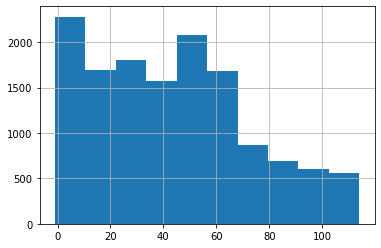

In [63]:
X_train.age.hist()

#### Interpretation Alert!!

I think that the data indicates that though the variation in house age does little to explain the variation in house price, there is still a significant effect as the overall F score of the simple model is significant! 

## Next up, let's take a look at square footage


In [80]:
print(X_train.columns)
X_train.head()

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'recent_reno', 'age'],
      dtype='object')


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,recent_reno,age
2498,2014-06-26,3,2.50,2370,5353,2.0,0,0,3,8,...,0,2009,0,98019,47.7333,-121.975,2130,6850,0,5
10932,2014-05-19,4,1.75,2080,13629,1.0,0,0,4,7,...,1040,1955,0,98178,47.4866,-122.232,1780,14659,0,59
15638,2014-06-27,1,1.00,700,2500,1.0,0,0,4,7,...,0,1907,0,98106,47.5662,-122.364,1340,5000,0,107
15099,2015-01-15,4,2.25,2490,7233,1.0,0,0,3,8,...,1030,1978,0,98023,47.3115,-122.396,2000,8000,0,36
15560,2014-12-05,3,3.50,1970,5079,2.0,0,0,3,8,...,290,2007,0,98144,47.5816,-122.296,1940,6000,0,7


In [71]:
size = ['sqft_living',
        'sqft_lot',
        "sqft_basement",
        "sqft_living15",
        "sqft_lot15"       
]
size_data = X_train[size]
size_data.head()

,sqft_living,sqft_lot,sqft_basement,sqft_living15,sqft_lot15
2498,2370,5353,0,2130,6850
10932,2080,13629,1040,1780,14659
15638,700,2500,0,1340,5000
15099,2490,7233,1030,2000,8000
15560,1970,5079,290,1940,6000


In [70]:
sizes = pd.concat([size_data, y_train], axis=1)
columns = list(sizes.columns)

formula = 'price' + '~' + '+'.join(list(size_data.columns))
print(columns,formula)
sizes.head()
model = ols(formula=formula, data=sizes).fit()

NameError: name 'size_data' is not defined

In [68]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     43.12
Date:                Sun, 18 Oct 2020   Prob (F-statistic):           5.33e-11
Time:                        10:02:43   Log-Likelihood:            -1.9715e+05
No. Observations:               13832   AIC:                         3.943e+05
Df Residuals:                   13830   BIC:                         3.943e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.734e+05   5663.510    101.241      0.000    5.62e+05    5.84e+05
age         -712.3704    108.484     -6.567      0.000    -925.014    -499.727
==============================================================================
Omnibus:                    13073.950   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1014162.003
Skew:                           4.379   Prob(JB):                         0.00
Kurtosis:                      44.024   Cond. No.                         92.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpretation Alert!

It seems that all but the square foot lot column is significant. I think that the Square foot lot column is actually the total square footage of the property, potentially not including the house. 

If it is the total square footage, then i should minus away the square footage of the house to find the size of the surrounding property

Perhaps the ratio between the lot and the property is important. Let's check for an interaction between the two variables.

Otherwise, all the othervariables need to be taken into account


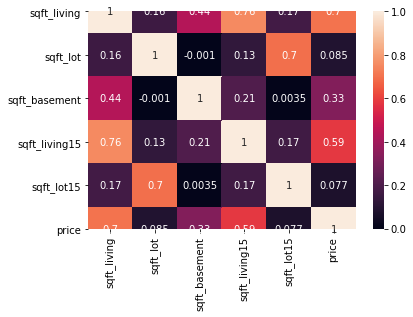

In [77]:
# Let's check for interactions between our size data first
sns.heatmap(pd.concat([size_data, y_train], axis=1).corr(), annot=True)

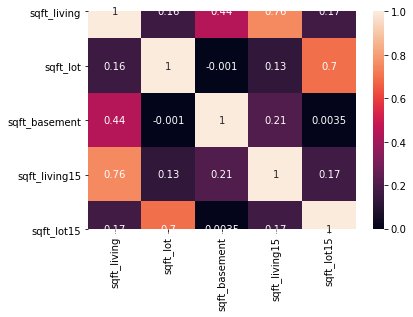

In [79]:
sns.heatmap(size_data.corr(), annot=True)

### Houses that are very close together seem to have very similar lot size

In addition, lot size and surrounding lot size has a correlation coefficient of over 0.5. 

Also, let's take a closer look at the basement column. It seems like maybe just having a basement is a benefit

In [81]:
X_train.sqft_basement.value_counts()

0       8367
500      148
800      138
600      133
700      132
        ... 
2610       1
2730       1
2850       1
915        1
475        1
Name: sqft_basement, Length: 278, dtype: int64

In [89]:
def have_basement(n):
    if n == 0:
        return 0
    else:
        return 1
    
basements = X_train.sqft_basement.apply(have_basement)
X_train['basement'] = basements
btest = pd.concat([X_train, y_train],axis=1)
nobase = btest[btest.basement == 0]
base = btest[btest.basement == 1]

print(stats.levene(nobase.price,base.price))
stats.ttest_ind(nobase.price, base.price, equal_var=False)

LeveneResult(statistic=134.69817096884273, pvalue=5.3502440834760515e-31)


Ttest_indResult(statistic=-19.384129817572532, pvalue=6.355936043895885e-82)

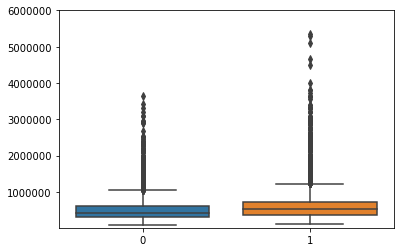

In [103]:
ax = sns.boxplot(data=[nobase.price, base.price])
ax.set_ylim(10000,6000000);

So it seems that having a basement does have a significant effect on the outcome of the house price! We still ahve to account for outliers, but now I'll make dummy columns and see how much they effect the outcome.

In [104]:
basement_dummies = pd.get_dummies(X_train.basement)

In [110]:
basement_dummies.columns = ['no', 'yes']
basement_dummies_test = pd.concat([basement_dummies, y_train], axis=1)

In [111]:
formula = 'price~no+yes'
model = ols(formula = formula, data=basement_dummies_test).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     447.8
Date:                Sun, 18 Oct 2020   Prob (F-statistic):           7.75e-98
Time:                        10:54:31   Log-Likelihood:            -1.9695e+05
No. Observations:               13832   AIC:                         3.939e+05
Df Residuals:                   13830   BIC:                         3.939e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.713e+05   2142.074    173.321      0.000    3.67e+05    3.75e+05
no          1.176e+05   3166.573     37.151      0.000    1.11e+05    1.24e+05
yes         2.536e+05   3593.776     70.573      0.000    2.47e+05    2.61e+05
==============================================================================
Omnibus:                    12991.339   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1000718.913
Skew:                           4.334   Prob(JB):                         0.00
Kurtosis:                      43.758   Cond. No.                     1.72e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.17e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [115]:
# Compare it with just leaving the basement size as it is
formula = 'price~sqft_basement+yes+no'
model = ols(formula=formula, data= pd.concat([y_train, X_train, basement_dummies], axis=1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     1058.
Date:                Sun, 18 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:59:12   Log-Likelihood:            -1.9619e+05
No. Observations:               13832   AIC:                         3.924e+05
Df Residuals:                   13829   BIC:                         3.924e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.566e+05   3499.017     73.340      0.000     2.5e+05    2.63e+05
sqft_basement   460.7758     11.463     40.198      0.000     438.308     483.244
yes            2.433e+04   6640.967      3.663      0.000    1.13e+04    3.73e+04
no             2.323e+05   4136.805     56.152      0.000    2.24e+05     2.4e+05
==============================================================================
Omnibus:                    11789.131   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           666698.638
Skew:                           3.792   Prob(JB):                         0.00
Kurtosis:                      36.156   Cond. No.                     6.97e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.17e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

AttributeError: 'OLSResults' object has no attribute 'score'

### Current model:

- month/season 
- sqaure footage lot/ square foot living space
- basement categorical and size
- location based on geospatial data


Yet to test:
- bedrooms
- bathrooms
- condition
- grade
- water front
- view
- zipcode
- floors


I need to normalize the valus. I think some, likee bedrooms will have a log relationship

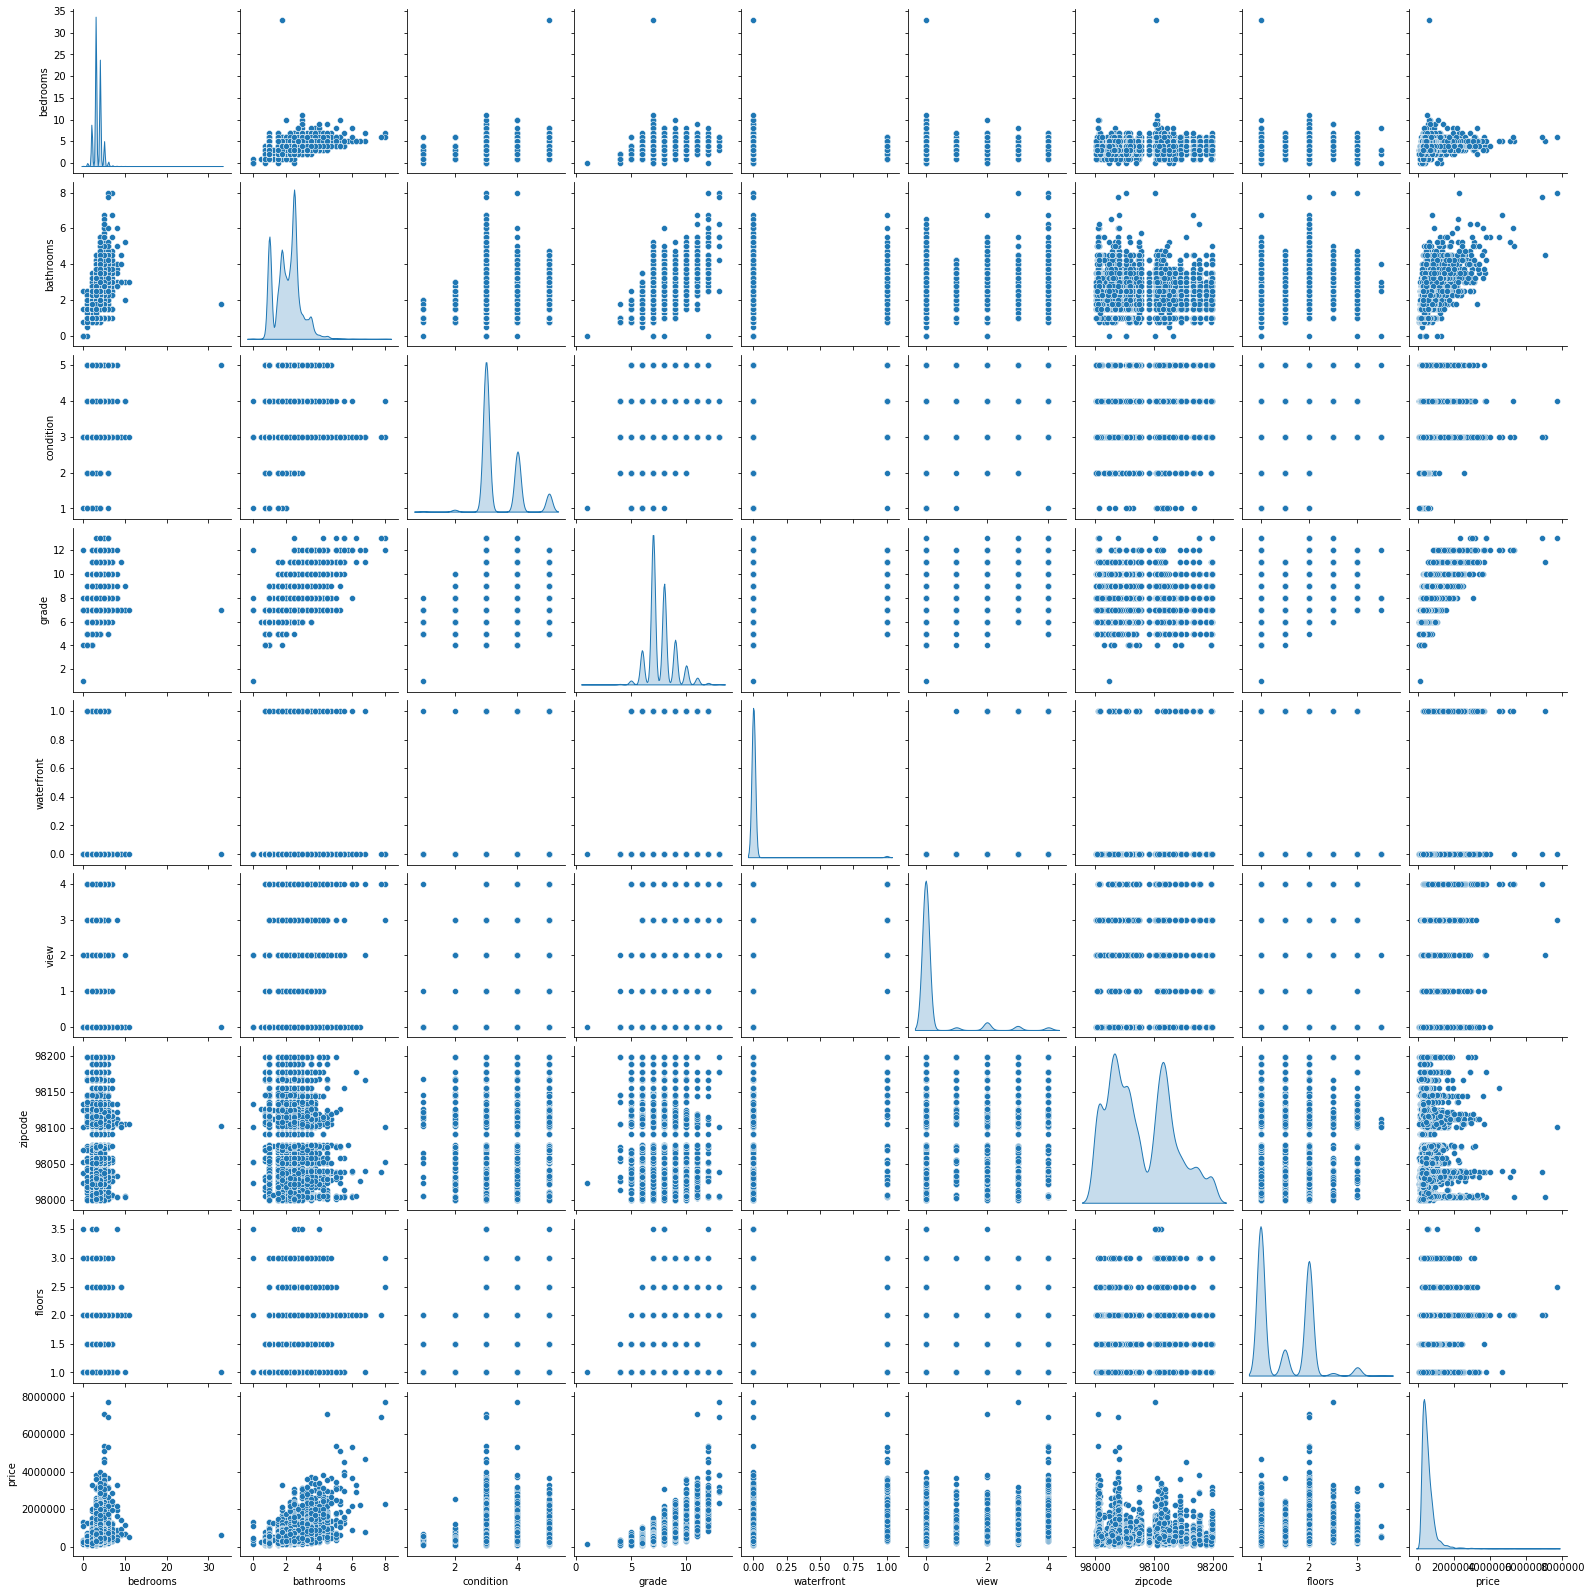

In [118]:
to_test = [
    "bedrooms",
    'bathrooms',
    'condition',
    'grade',
    'waterfront',
    'view',
    'zipcode',
    'floors'
]

test_df = pd.concat([X_train[to_test], y_train], axis=1)
sns.pairplot(test_df, diag_kind='kde')

In [129]:
zipcodes_five = list(test.zipcode.unique())

In [136]:
# Let's drop the last digit of the zipcodes and see if how many unique valueswe have

def drop_last(n):
    return int(str(n)[:-1])

zipcodes_four = list(test_df.zipcode.apply(lambda x: drop_last(x)).unique())
test_df['zipcodes_four'] = test_df.zipcode.apply(lambda x: drop_last(x))

In [137]:
def price_by_zip(df, zipcodes):
    # find and return all prices where zipcode 
    

SyntaxError: unexpected EOF while parsing (<ipython-input-137-3f38d15a3172>, line 3)

In [156]:
# make dummy columns out of the zip codes
zipcode_dummies = pd.get_dummies(X_train.zipcode)
zipcode_dummies.columns = [str(x) for x in zipcode_dummies.columns]
[(x) for x in zipcode_dummies.columns]

['98001',
 '98002',
 '98003',
 '98004',
 '98005',
 '98006',
 '98007',
 '98008',
 '98010',
 '98011',
 '98014',
 '98019',
 '98022',
 '98023',
 '98024',
 '98027',
 '98028',
 '98029',
 '98030',
 '98031',
 '98032',
 '98033',
 '98034',
 '98038',
 '98039',
 '98040',
 '98042',
 '98045',
 '98052',
 '98053',
 '98055',
 '98056',
 '98058',
 '98059',
 '98065',
 '98070',
 '98072',
 '98074',
 '98075',
 '98077',
 '98092',
 '98102',
 '98103',
 '98105',
 '98106',
 '98107',
 '98108',
 '98109',
 '98112',
 '98115',
 '98116',
 '98117',
 '98118',
 '98119',
 '98122',
 '98125',
 '98126',
 '98133',
 '98136',
 '98144',
 '98146',
 '98148',
 '98155',
 '98166',
 '98168',
 '98177',
 '98178',
 '98188',
 '98198',
 '98199']

In [152]:
test_df.groupby(['zipcode']).price.median().sort_values(ascending=False)

zipcode
98039    1880000.0
98004    1185000.0
98040     969000.0
98112     950000.0
98006     760000.0
           ...    
98198     265000.0
98001     260000.0
98032     247500.0
98168     235000.0
98002     229950.0
Name: price, Length: 70, dtype: float64

In [158]:
formula = 'price' + '~' + '+'.join(zipcode_dummies.columns)
print(formula)
# model = ols(formula=formula, data= pd.concat([zipcode_dummies, y_train]))

price~98001+98002+98003+98004+98005+98006+98007+98008+98010+98011+98014+98019+98022+98023+98024+98027+98028+98029+98030+98031+98032+98033+98034+98038+98039+98040+98042+98045+98052+98053+98055+98056+98058+98059+98065+98070+98072+98074+98075+98077+98092+98102+98103+98105+98106+98107+98108+98109+98112+98115+98116+98117+98118+98119+98122+98125+98126+98133+98136+98144+98146+98148+98155+98166+98168+98177+98178+98188+98198+98199


In [161]:
lr = LinearRegression()
lr.fit(zipcode_dummies, y_train)
zipcode_y_hat = lr.predict(zipcode_dummies)

In [163]:
mean_squared_error(y_train,zipcode_y_hat)**0.5

291776.5282186117